In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_palette('husl')
from sklearn.preprocessing import LabelEncoder, StandardScaler, QuantileTransformer, MinMaxScaler, PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, MissingIndicator
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier, LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as skm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import sklearn.svm as svm
from math import isclose

In [2]:
%logstop
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider, FloatSlider, fixed

Logging hadn't been started.


# Question One

In [3]:
# Load Training Data From Disc
data = pd.read_csv("exam_raw.csv")

- Here, I'll take a brief look at the data for the purpose of exploratory analysis and description of the overall data.

In [4]:
data.head()

Vmag    Plx  e_Plx    B-V SpType
0  9.10   3.54   1.39  0.482     F5
1  9.27  21.90   3.10  0.999    K3V
2  6.61   2.81   0.63 -0.019     B9
3  8.06   7.75   0.97  0.370    F0V
4  8.55   2.87   1.11  0.902  G8III

In [5]:
data.tail()

Vmag    Plx  e_Plx    B-V SpType
81935  9.22   0.71   2.26  0.347     A3
81936  7.20  13.13   0.99  0.443   F5IV
81937  7.74   3.01   1.03  1.378  K1III
81938  7.21   3.14   0.69  0.020     A0
81939  8.71   2.34   0.76  1.015     K0

## Missing Data?

- An important question to ask is how many observation, if any, have missing data and what proportion of entire set this represents

In [6]:
print("Proportion of missing values")
print(data.isnull().sum()*100/len(data))
print("\n")
print("Proportion of missing values")
data.isna().sum()*100/len(data)

Proportion of missing values
Vmag      0.000000
Plx       0.000000
e_Plx     0.000000
B-V       0.000000
SpType    2.434708
dtype: float64


Proportion of missing values


Vmag      0.000000
Plx       0.000000
e_Plx     0.000000
B-V       0.000000
SpType    2.434708
dtype: float64

# Clean Data

- The exploratory analysis above reveals that ~$2$% of the obervation have missing $SpType$ entries (labels).  

- To avoid training bias, the rows with missing labels will be droped using $dropna()$ method.

- Subsequently, I'll drop rows where $e_{plx} \approx Plx$.

- The algorithm to use for this would be checking if the rounded up values of $P_{lx}$ and $e_{Plx}$ are equal. The observation is kept if otherwise. 

- This makes the Tolerance limit to be ~ $0.8$

In [7]:
data = data.dropna()
data = data[np.round(data["e_Plx"]) != np.round(data["Plx"])]

In [8]:
data.shape

(73801, 5)

- Next, rows that to not satisfy the Luminousity class in the SpType string label will be droped

In [9]:
data = data[data["SpType"].str.endswith(("I", "II", "III", "IV", "V", "VI", "VII"))]

data.head()

Vmag    Plx  e_Plx    B-V SpType
1  9.27  21.90   3.10  0.999    K3V
3  8.06   7.75   0.97  0.370    F0V
4  8.55   2.87   1.11  0.902  G8III
7  8.59  10.76   1.10  0.489    F6V
9  8.43   4.06   1.16  1.484  K4III

- Physical examination of the data reveals that observations that do not confirm to the configuration -- where the $SpType$ enrty is a string with first two characters specifing MK classification out of $“OBAFGKMRS”$, followed by single digit integer and followed by Luminosity class denoted by roman numerals from I to VII -- exist in the data. 

- Examples are shown below

In [10]:
data[data["SpType"].str.len() > 5]

Vmag    Plx  e_Plx    B-V     SpType
98     8.29   2.83   1.09  1.183  K1IIICNIV
927    6.86   6.48   0.94  1.096  K1IIICNIV
4055   6.61  13.28   0.79  0.905  K0IIICNIV
5096   8.20   5.02   1.02  1.183  K2IIICNII
24854  7.72   5.44   0.95  1.225  K2IIICNII
25527  7.90   4.75   0.66  1.073  K1IIICNIV
31663  9.10   3.11   1.40  1.214  K0IIICNII
39116  5.49   4.27   0.68  1.345  K2IIICNII
43068  8.57   3.28   1.08  1.222  K2IIICNII
65848  5.70  11.31   0.60  1.169  K1IIICNII
75929  6.96   2.66   0.87  1.490   G6IICNIV

- Such observations with bad data be dropped as well. 

- Since the maximum possible length of such a string is $Five$, any observation with string labels longer than $Five$ will be dropped. 

In [11]:
data = data[data["SpType"].str.len() <= 5]
data.head()

Vmag    Plx  e_Plx    B-V SpType
1  9.27  21.90   3.10  0.999    K3V
3  8.06   7.75   0.97  0.370    F0V
4  8.55   2.87   1.11  0.902  G8III
7  8.59  10.76   1.10  0.489    F6V
9  8.43   4.06   1.16  1.484  K4III

- Lastly, I will investigate the $SpType$ column to confirm that the $SpType$ enrty is a string with first letter specifing MK classification out of $“OBAFGKMRS”$.

In [12]:
data[~ data["SpType"].str.upper().str.startswith(("O", "B", "A", "F", "G", "K", "M", "R", "S"))].head()

Vmag    Plx  e_Plx    B-V SpType
306    8.12   2.15   1.05  2.530   C5II
1797   9.52  10.27   1.08  0.735   C6II
12686  5.71   2.48   0.56  2.419   C5II
19144  9.18  -1.15   1.48  2.750   C4II
20389  8.96   1.26   1.51  2.928   C5II

- Again, such bad observations will be dropped.

In [13]:
data = data[data["SpType"].str.upper().str.startswith(("O", "B", "A", "F", "G", "K", "M", "R", "S"))]
data.head()

Vmag    Plx  e_Plx    B-V SpType
1  9.27  21.90   3.10  0.999    K3V
3  8.06   7.75   0.97  0.370    F0V
4  8.55   2.87   1.11  0.902  G8III
7  8.59  10.76   1.10  0.489    F6V
9  8.43   4.06   1.16  1.484  K4III

## Feature Engineering

- Now, the $e_{plx}$ column will be dropped to extract feature vectors for training

- These will then be saved to file titled $CleanedData.csv$

In [14]:
data_train = data.drop("e_Plx", axis=1)

In [15]:
data_train.to_csv("cleaned_data.csv", header=True, index=False)

## Label Encoding

- Here, the labels will be encoded using the $LabelEncoder$ transformer in order to preserve the ordering of the labels 

- I'll do this by first creating a fifth column corresponding to the Luminous Class of the original labels.

In [16]:
# List containing all possible classes

luminousclass = ["I", "II", "III", "V", "IV", "VI", "VII"]

In [17]:
# Iterate over classes in the list and set Luminousity class appropriately

for clas in luminousclass:
    data_train.loc[data_train["SpType"].str.endswith(clas), "Luminousity Class"] = clas

In [18]:
data_train.head()

Vmag    Plx    B-V SpType Luminousity Class
1  9.27  21.90  0.999    K3V                 V
3  8.06   7.75  0.370    F0V                 V
4  8.55   2.87  0.902  G8III               III
7  8.59  10.76  0.489    F6V                 V
9  8.43   4.06  1.484  K4III               III

- Since Luminous Class has been extracted, the labels can now be encoded using LabelEncoder

In [19]:
le = LabelEncoder()

In [20]:
data_train["label"] = le.fit_transform(data_train["Luminousity Class"])

data_train.to_csv("cleaned_data2.csv", header=True, index=False)

In [21]:
data_train.head()

Vmag    Plx    B-V SpType Luminousity Class  label
1  9.27  21.90  0.999    K3V                 V      3
3  8.06   7.75  0.370    F0V                 V      3
4  8.55   2.87  0.902  G8III               III      1
7  8.59  10.76  0.489    F6V                 V      3
9  8.43   4.06  1.484  K4III               III      1

## Examine Exam Question Data

- Now that the raw data has been cleaned, we can examine the exam question data to see if missing data exists

In [22]:
# Load Exam Data

exam_data = pd.read_csv("exam_question.csv")
exam_data = exam_data[["Vmag", "Plx", "B-V"]]

- Do missing data exist?

In [23]:
print("Proportion of missing values")
print(exam_data.isnull().sum())
print("\n")
print("Proportion of missing values")
print(exam_data.isna().sum())

Proportion of missing values
Vmag    0
Plx     0
B-V     0
dtype: int64


Proportion of missing values
Vmag    0
Plx     0
B-V     0
dtype: int64


- This function does not identify any missing data, however, physical examination of the data shows there several missing values. 

- To remedy this, I convert each feature to numeric values and use the error paramter to parse invalid data as NaN


In [24]:
exam_data["Vmag"] = pd.to_numeric(exam_data["Vmag"], downcast="float", errors='coerce')
exam_data["Plx"] = pd.to_numeric(exam_data["Plx"], downcast="float", errors='coerce')
exam_data["B-V"] = pd.to_numeric(exam_data["B-V"], downcast="float", errors='coerce')

- Now, we check again for missing values

In [25]:
print("Number of missing values")
print(exam_data.isnull().sum())
print("\n")
print("Number of missing values")
print(exam_data.isna().sum())

Number of missing values
Vmag    0
Plx     2
B-V     1
dtype: int64


Number of missing values
Vmag    0
Plx     2
B-V     1
dtype: int64


- The code above shows that missing data exist

- Since the $SimpleImputer$ does not permit flexibility of the imputing strategy, the $IterativeImputer$, which linear regresses the training data is favorable for such proportion of missing data.

In [26]:
X_raw = data_train[["Vmag", "Plx", "B-V"]]

imp = IterativeImputer(max_iter=10, random_state=0)

imp.fit(X_raw)

X_exam = imp.transform(exam_data)

exam_data[["Vmag", "Plx", "B-V"]] = X_exam

## Select Features and Label

- Here, we select the $Vmag$, $Plx$ and $B_V$ columns as features and $Label$ column as the $y$ labels

In [27]:
X = data_train[["Vmag", "Plx", "B-V"]]

In [28]:
y = data_train["label"]

## Exploratory analysis

- A pairplot is uselful to visualize the correlation and distribution of the dataset.

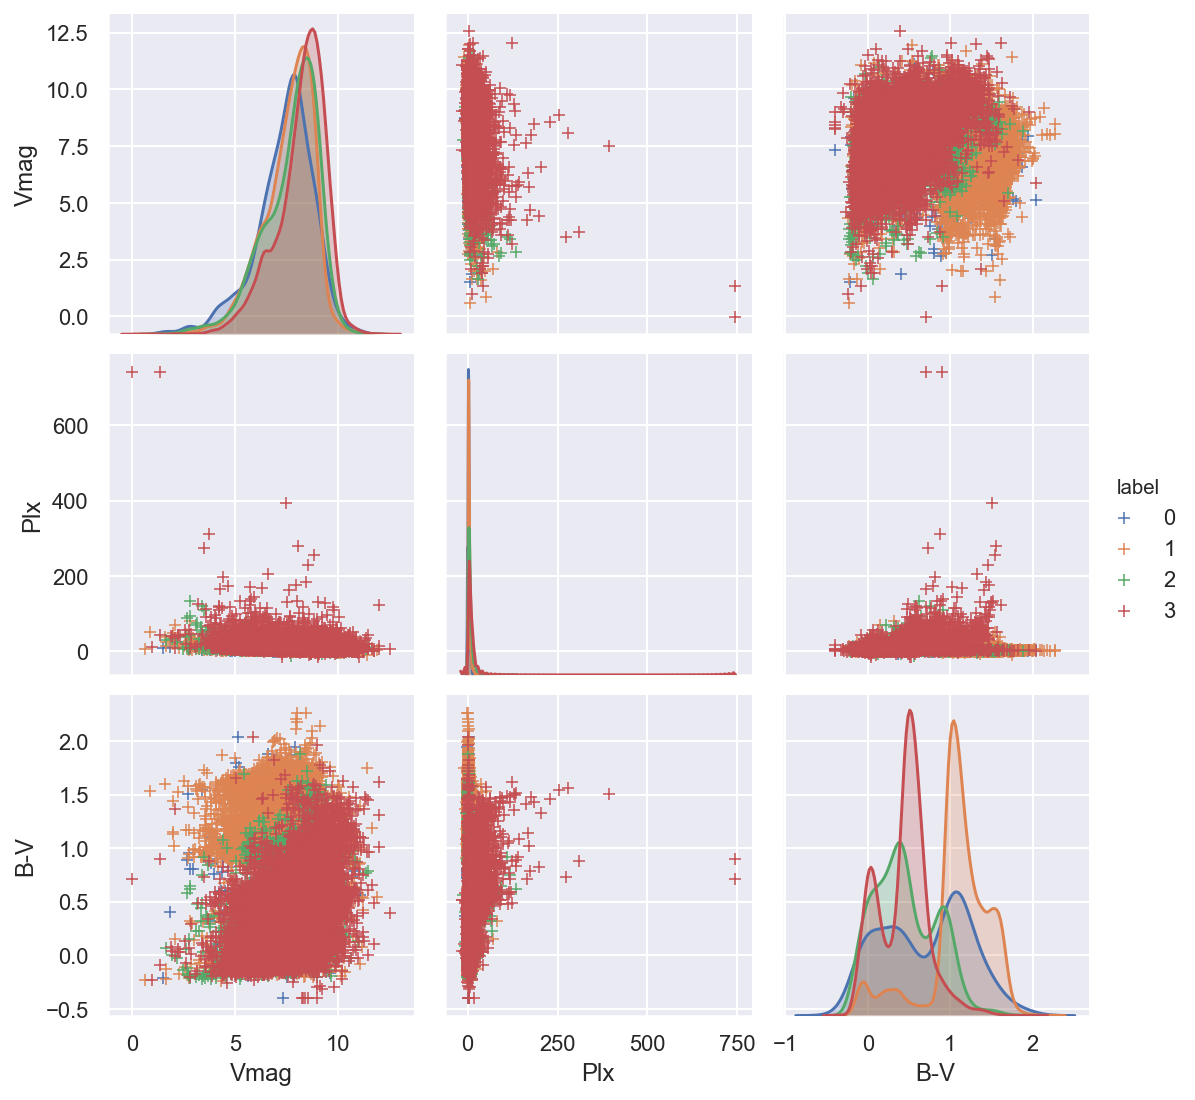

In [29]:
g = sns.pairplot(data_train, hue='label', markers="+")

- The exploratory analysis shown above already indicates that the features require some data preprocessing or transformations because the raw features exists on different scales with significant varaince in numerical values. Added to this is the fact that some classes appear to have a bimodal distribution of certain features.

- Generally, the features do not appear to have a gaussian distribution, however, the $B_V$ and $V_{mag}$ features have some semblance of such distribution. 

- This tempts one to apply preprocessing technqiues like the $MinMaxScaler$

In [30]:
# Scale Using MinMaxScaler

scaler_minmax = MinMaxScaler()
Xs = scaler_minmax.fit_transform(X)

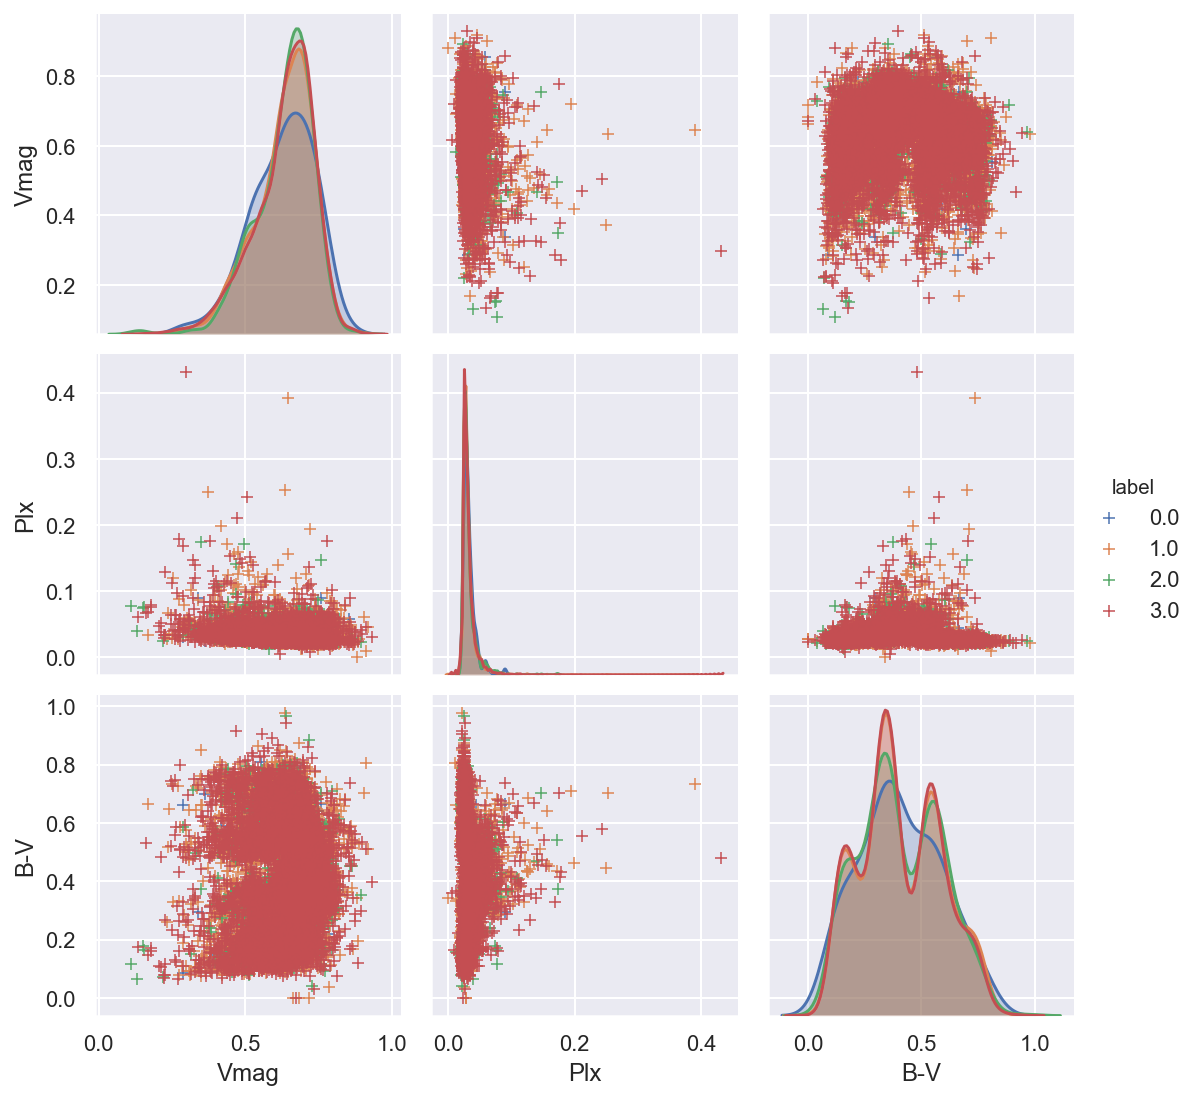

In [31]:
# Visualize result

df = pd.DataFrame(Xs, columns=["Vmag", "Plx", "B-V"])
df["label"] = data_train["label"]
g = sns.pairplot(df, hue="label", markers="+")

- It's evident that $MinMaxScaler$ doesn't provide the desired uniform distribution as several outliers still exists in the data, particularly the $P_{lx}$ feature 

- A particularly useful transformation for obtaining uniformly distributied data is the $QuantileTransformer$ 

In [32]:
# Using the Quantile Transformer 

quantile_scaler = QuantileTransformer(output_distribution="uniform")
Xq = quantile_scaler.fit_transform(X)

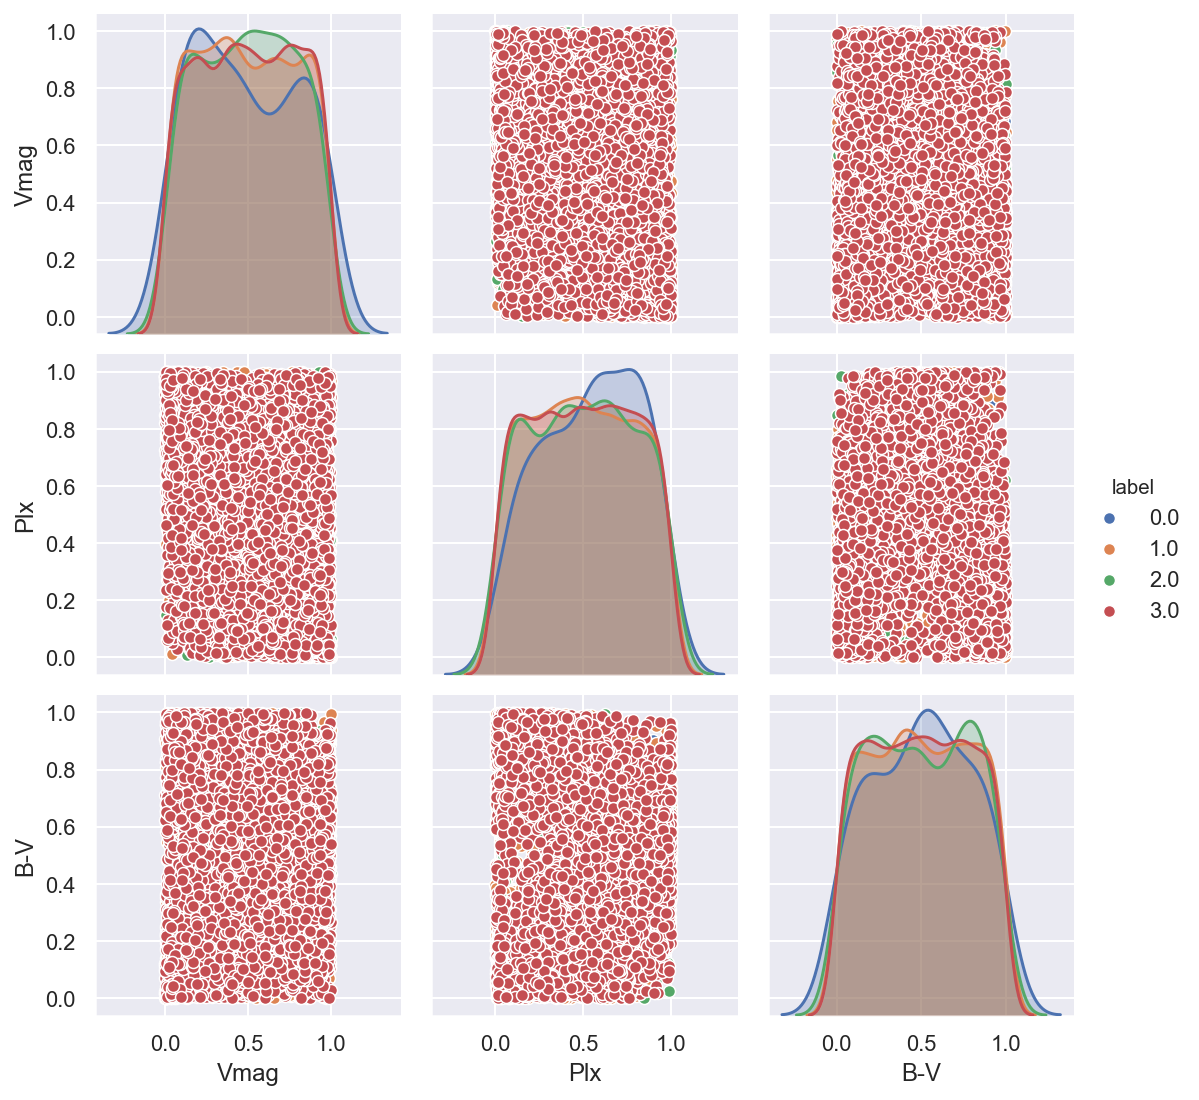

In [33]:
# Visualize result

df = pd.DataFrame(Xq, columns=["Vmag", "Plx", "B-V"])
df["label"] = data_train["label"]
g = sns.pairplot(df, hue="label")

- Now, based on the pairplot above, it is evident that the data appears uniformly distributed with less skew and would be more suitable for training.

## 3D Visualization of the Feature Space

- Right after transformation, It will be useful to visualize the data in the 3D feature space to have a sense of how sparse or dense the data is distributed. 

- A function to implement this has been written below

In [34]:
def plot_3D(X, y, elevation, azimth):
    
    def plotter(elev=elevation, azim=azimth):
        
        font = {'family': 'serif', 'color': 'black', 'weight': 'bold', 'size': 16}
        fig = plt.figure(figsize=(14, 8))
        ax = plt.axes(projection='3d')
        p = ax.scatter(*X.T, c=y, cmap="jet")
        ax.view_init(elev, azim)
        ax.set_xlabel('$V_{mag}$', fontdict=font, labelpad=10)
        ax.set_ylabel('$P_{lx}$', fontdict=font, labelpad=10)
        ax.set_zlabel('$e_{Plx}$', fontdict=font, labelpad=10)
        fig.colorbar(p)
        plt.show(block=False)
        
    return plotter

## Split Data Into Train and Test sets

- Before calling the $plot\_3D$ function, the I will split the data into training and test sets to visualize them seperately.

- As a rule of thumb, the $QuantileTransformer$ will be fit on the training set and not the entire data since the test set is supposed to act as fresh unseen data. 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy(), test_size=0.2, random_state=9)

quantile_scaler = QuantileTransformer()
X_train = quantile_scaler.fit_transform(X_train)
X_test = quantile_scaler.transform(X_test)

#### 3D Training Plot  

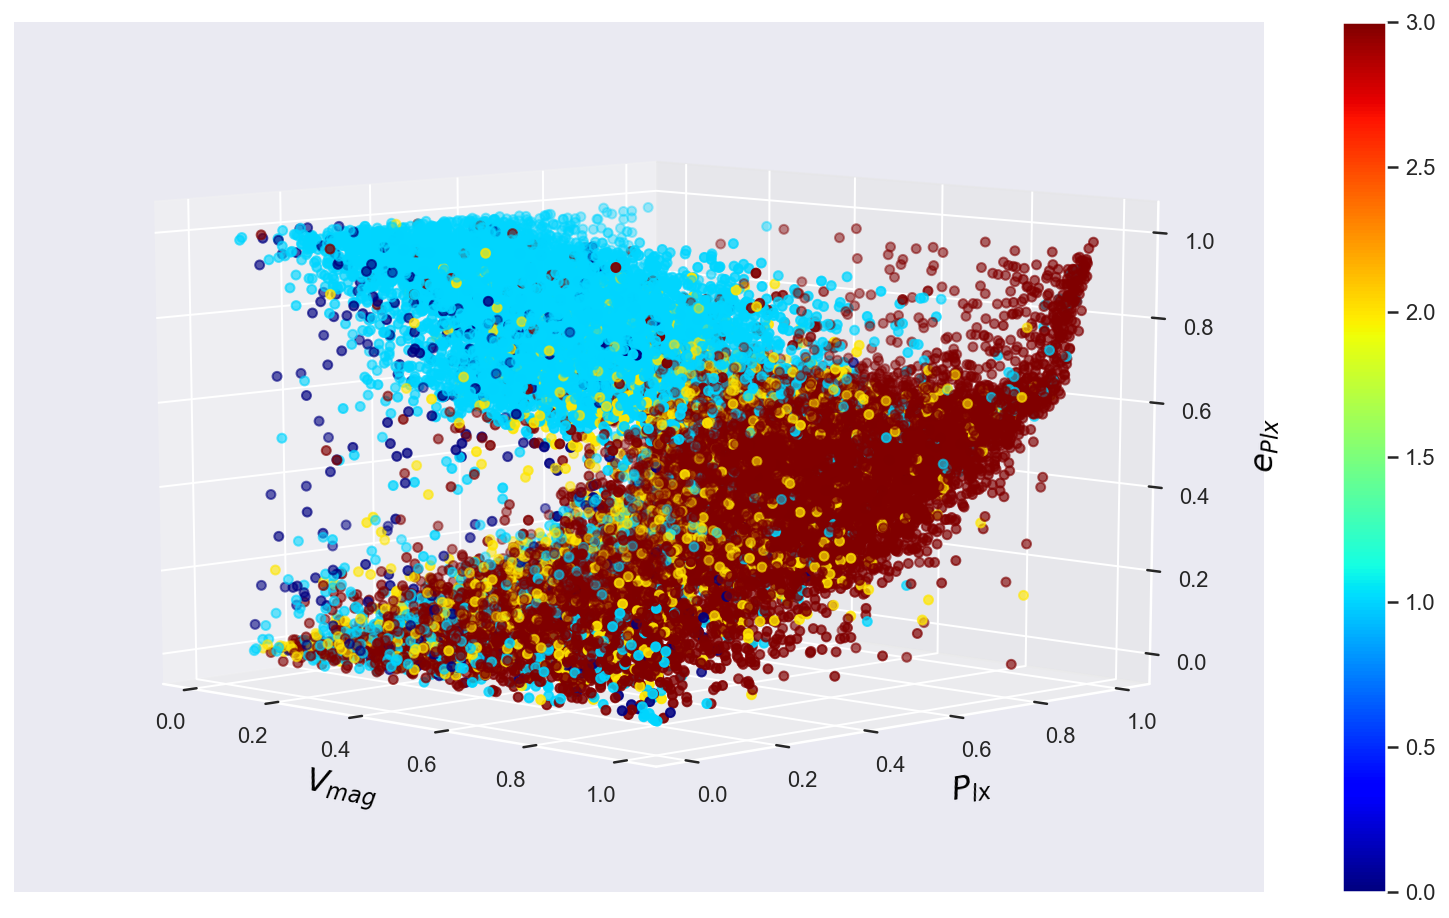

<function __main__.plot_3D.<locals>.plotter(elev=10, azim=-45)>

In [36]:
interact(plot_3D(X_train, y_train, elevation=10, azimth=-45))

#### 3D Test Plot  

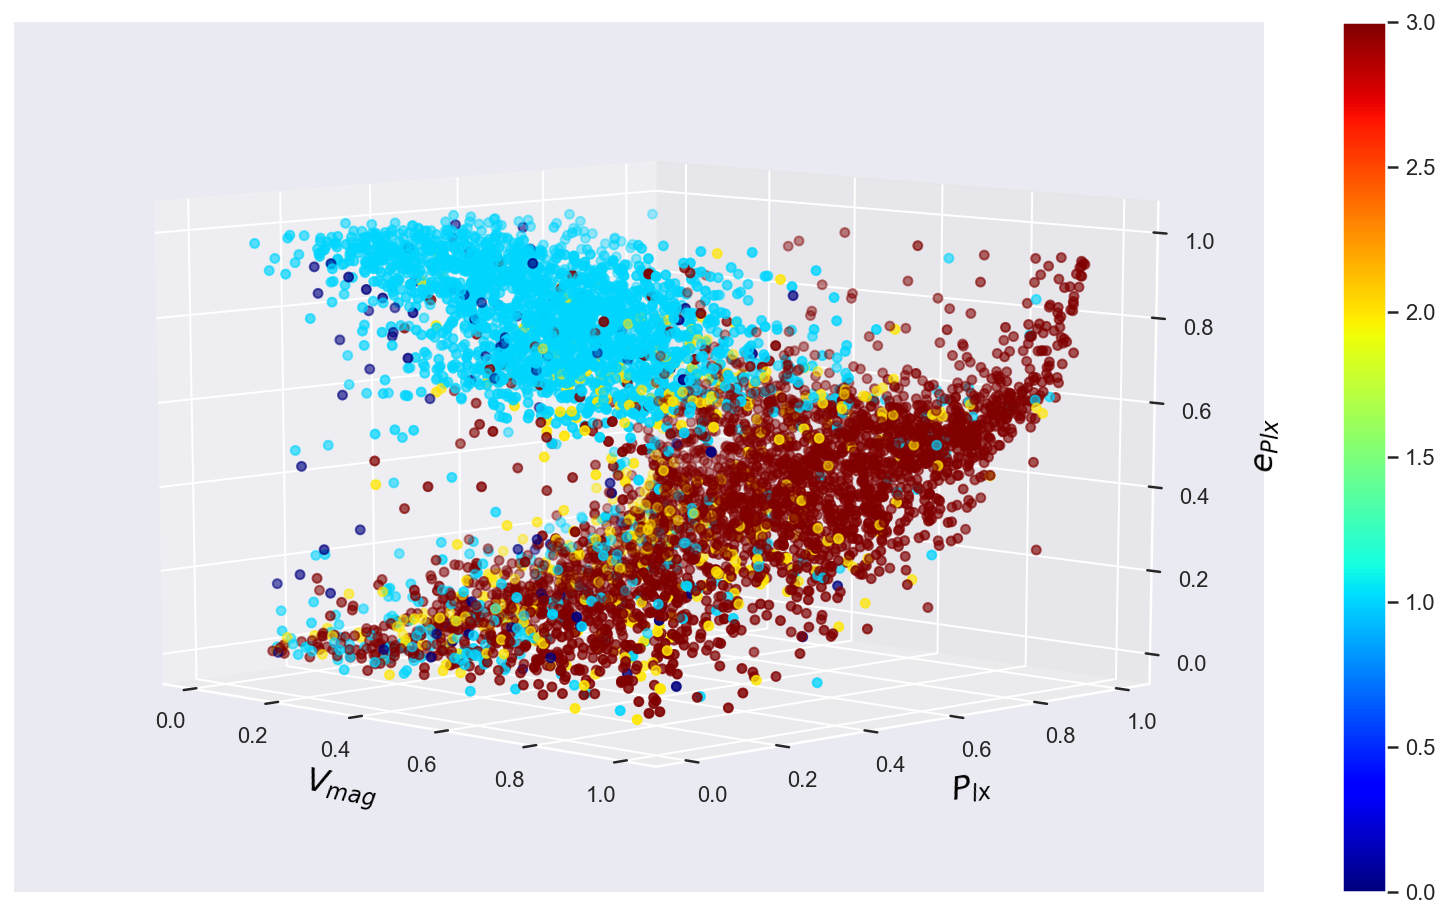

<function __main__.plot_3D.<locals>.plotter(elev=10, azim=-45)>

In [37]:
interact(plot_3D(X_test, y_test, elevation=10, azimth=-45))

- The above $3D$ plots indicate that the after splitting the data into Test and Training sets, the test set is representative of the training set

## Classifier Training

- Here, I will try out the following classifiers;

$$LogisticRegression$$

$$RandomForestClassifier$$

$$SupportVectorMachine$$

- After training, I will collect and compare several metrics of the resulting prediction and pick the classifier with the best scores

In [38]:
# Create DataFrame to Store Metrics

metrics_on_training = pd.DataFrame(columns=["Accuracy", "Precision", "R Score", "MSE"], 
                                   index=["Logistic Regression", "Random Forest", "SVM_rbf", "SVM_poly"],
                                   dtype=float)

metrics_on_test = pd.DataFrame(columns=["Accuracy", "Precision", "R Score", "MSE"], 
                                   index=["Logistic Regression", "Random Forest", "SVM_rbf", "SVM_poly"], 
                                   dtype=float)

y_df = pd.DataFrame(y_test, columns=["y_test"])

#### Logistic Regression

- Despite using the $QuantileTransformer$, there still appears to be a few outliers in the data. 

- To penalize these outliers and avoid overfitting, the $L_{2}$ Ridge penalty will be used since most features appear to determine a star's Luminousity Class.

In [39]:
## Train Model
LogReg = LogisticRegression(C=0.03906939937054617, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogReg.fit(X_train, y_train)

## Make Predictions

y_test_pr = np.round(LogReg.predict(X_test))
y_train_pr = np.round(LogReg.predict(X_train))

y_df["LogReg"] = y_test_pr

metrics_on_training.loc["Logistic Regression", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training.loc["Logistic Regression", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training.loc["Logistic Regression", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training.loc["Logistic Regression", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100



metrics_on_test.loc["Logistic Regression", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test.loc["Logistic Regression", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test.loc["Logistic Regression", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test.loc["Logistic Regression", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### Random Forest Classifier

- Since the performance of a single decision tree will be limited, a better approach will be to aggregate the predictions of multiple trees. 

- The expectation is that aggregation should perform better than a single predictor. Hence a Random Forest was chosen


In [40]:
rfc = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rfc.fit(X_train, y_train)


## Make Predictions

y_test_pr = np.round(rfc.predict(X_test))
y_train_pr = np.round(rfc.predict(X_train))

y_df["RFC"] = y_test_pr

metrics_on_training.loc["Random Forest", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training.loc["Random Forest", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training.loc["Random Forest", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training.loc["Random Forest", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test.loc["Random Forest", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test.loc["Random Forest", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test.loc["Random Forest", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test.loc["Random Forest", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### Support Vector Machine

- Since the plotted distribution indicates the data is not completely linearly separable, the Linear SVM is not a favorable kernel method to use.  

- To remedy this, the RBF and Poly kernel methods will be used and subsequently compared. 

In [41]:
clf_rbf = svm.SVC(C=0.9191919191919192, break_ties=False, cache_size=200, class_weight=None,
                coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
                kernel='rbf', max_iter=-1, probability=False, random_state=None,
                shrinking=True, tol=0.001, verbose=False)

clf_rbf.fit(X_train, y_train)


## Make Predictions

y_test_pr = np.round(clf_rbf.predict(X_test))
y_train_pr = np.round(clf_rbf.predict(X_train))

y_df["RBF_SVM"] = y_test_pr

metrics_on_training.loc["SVM_rbf", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training.loc["SVM_rbf", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training.loc["SVM_rbf", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training.loc["SVM_rbf", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test.loc["SVM_rbf", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test.loc["SVM_rbf", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test.loc["SVM_rbf", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test.loc["SVM_rbf", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

In [42]:
clf_poly = svm.SVC(kernel="poly", degree=2, C=0.01)
clf_poly.fit(X_train, y_train)


## Make Predictions

y_test_pr = np.round(clf_poly.predict(X_test))
y_train_pr = np.round(clf_poly.predict(X_train))

y_df["POLY_SVM"] = y_test_pr

metrics_on_training.loc["SVM_poly", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training.loc["SVM_poly", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training.loc["SVM_poly", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training.loc["SVM_poly", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100

metrics_on_test.loc["SVM_poly", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test.loc["SVM_poly", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test.loc["SVM_poly", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test.loc["SVM_poly", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100


### Training Metrics Heatmap

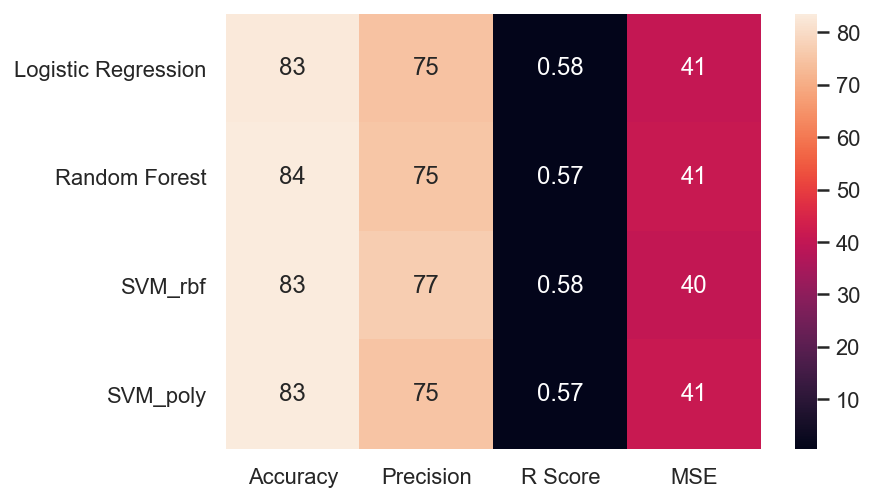

In [43]:
sns.heatmap(data=metrics_on_training, annot=True)

### Test Metrics Heatmap

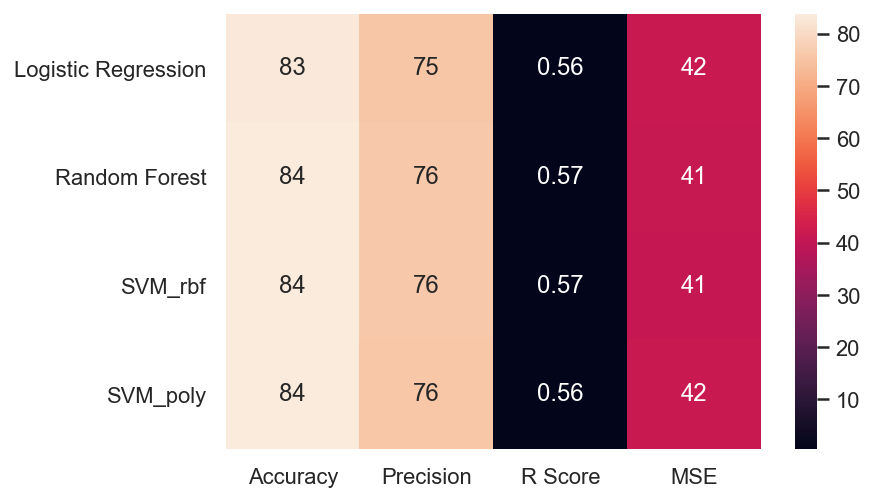

In [44]:
sns.heatmap(data=metrics_on_test, annot=True)

## Comments

- The heatmaps above indicate that the four models have approximately equal metrics. However, the $Support$ $Vector$ $Machine$ with a $Gaussian$ $Kernel$ is a preferable algorithm since it has the lowest $MSE$ and highest $R$-$score$ of all trained models.

- However, it is important to note that these models do a poor job when taking into account the very low R-scores and overly high MSE's.

- A plausible reason for this can be immediately seen from the 3D visualization done above; The data appears too dense with poorly defined, (overly clustered, finely mixed) classes, despite transoformation and scaling. 

- For example, stars with Lunminousity Classes $I$ are finely mixed with stars in classes $II$.

## Predict Exam Data

- Now, I will run the the $Support$ $Vector$ $Machine$ with a $Gaussian$ $Kernel$ to predict the encoded $Luminousity$ $Classes$ of the exam question data

- Before that is done, the features of the exam data have to be transformed using the $QuantileTransformer$ fitted to the raw training data

- Subsequently, I will use the inverse tramsform method of the $Label Encoder$, already fitted to the taw training data, to extract the $Lunminousity$ $Class$ on the $I - VII$ scale

- This prediction will be saved to the exam_data DataFrame as $LuminousityClass\_Q1$, where $Q1$ represents $Question 1$

In [45]:
X_exam = quantile_scaler.transform(exam_data)

In [46]:
y_exam = clf_rbf.predict(X_exam)

y_exam = le.inverse_transform(y_exam)

In [47]:
exam_data["LuminousityClass_Q1"] = y_exam

# Question Two

## Giants and Dwarfs

- Here, I'll first implement an algorithm that labels obeservations with Luminoustity Classes $I, II,$ and $III$ as $Dwarfs$ and others as $Giants$

- In the current dataset "$data\_train$", the luminousity classes from $I - VII$ have been encoded using $LabelEncoder$ to range from $0 - 6$ respectively. 

- Subsequenly, $Dwarfs$ will be labelled $0$ and $Giants$, $1$ in a new column called $ClassType$



In [48]:
# Label Stars with "luminousity Classes" of "I, II, III" as Dwarfs === 0
data_train.loc[(data_train["Luminousity Class"] == "I") | (data_train["Luminousity Class"] == "II") | 
               (data_train["Luminousity Class"] == "III"), "ClassType"] = 0

In [49]:
# Label Stars with "luminousity Classes" of "IV, V, VI, VII"  as Giants === 1
data_train.loc[(data_train["Luminousity Class"] == "IV") | (data_train["Luminousity Class"] == "V") |
               (data_train["Luminousity Class"] == "VI") | (data_train["Luminousity Class"] == "VII")
               , "ClassType"] = 1

In [50]:
data_train.head()

Vmag    Plx    B-V SpType Luminousity Class  label  ClassType
1  9.27  21.90  0.999    K3V                 V      3        1.0
3  8.06   7.75  0.370    F0V                 V      3        1.0
4  8.55   2.87  0.902  G8III               III      1        0.0
7  8.59  10.76  0.489    F6V                 V      3        1.0
9  8.43   4.06  1.484  K4III               III      1        0.0

In [51]:
#Features

X = data_train[["Vmag", "Plx", "B-V"]]

#Labels
y = data_train["ClassType"]

## Split Data Into Train and Test sets

- Before calling the $plot\_3D$ function, the I will split the data into training and test sets to visualize them seperately.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, random_state=9)

## 3D Visualization Pre-Transformation

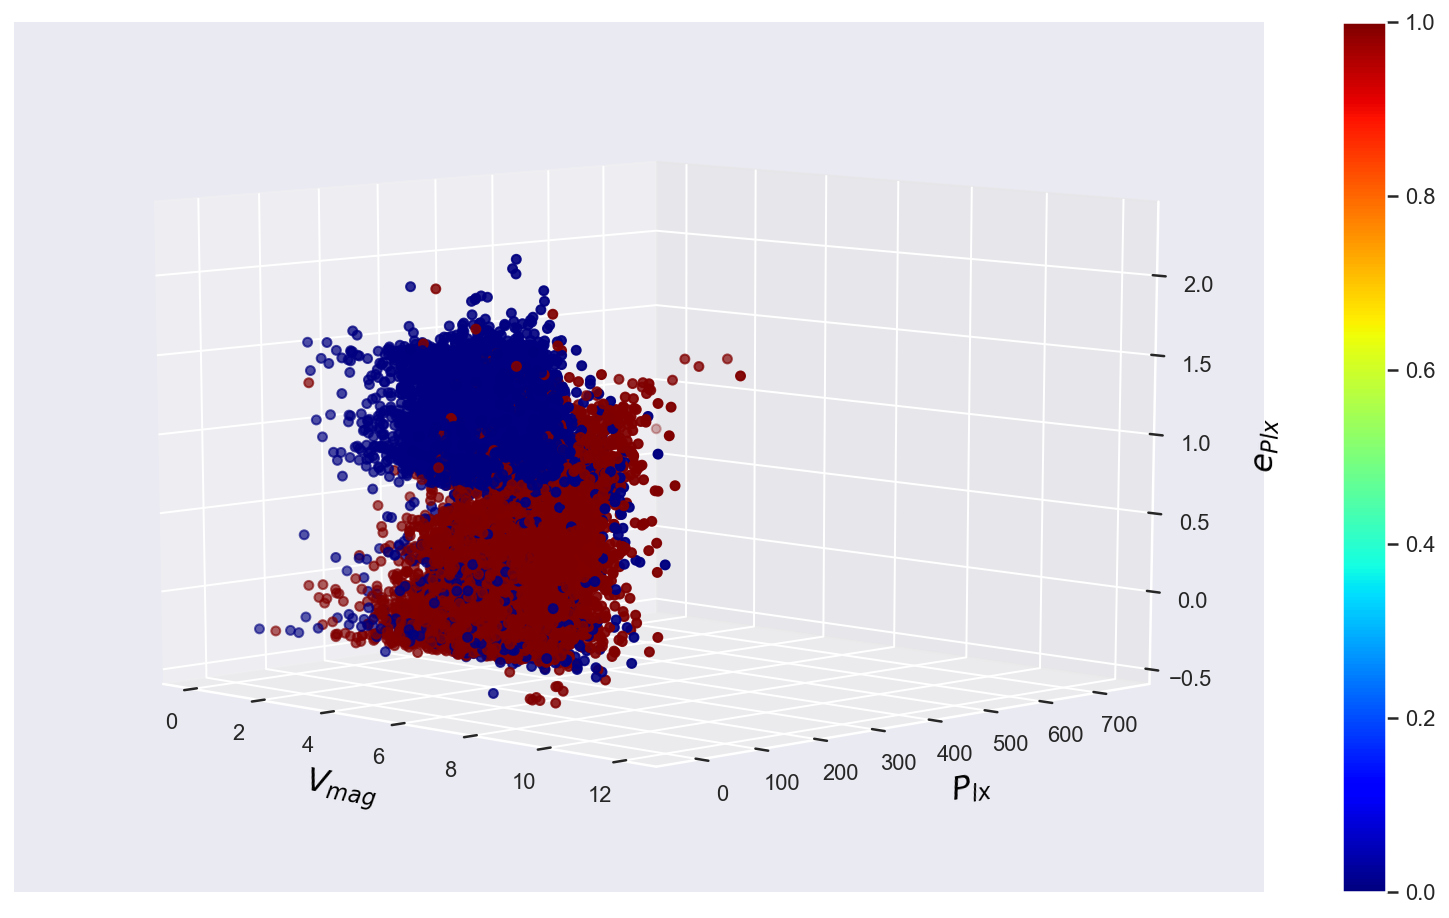

<function __main__.plot_3D.<locals>.plotter(elev=10, azim=-45)>

In [53]:
interact(plot_3D(X_train, y_train, elevation=10, azimth=-45))

- This visuaization doesn't show clearly defined $Giant$ and $Dwarf$ classes, therefore a more uniform transformer is required


- As a rule of thumb, the $QuantileTransformer$ will be fit on the training set and not the entire data.

In [54]:
#Using the Quantile Transformer
X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy(), test_size=0.3, random_state=9)

quantile_scaler = QuantileTransformer()

X_train = quantile_scaler.fit_transform(X_train)
X_test = quantile_scaler.transform(X_test)


## 3D Visualization Post-Transformation

#### 3D Training Plot 

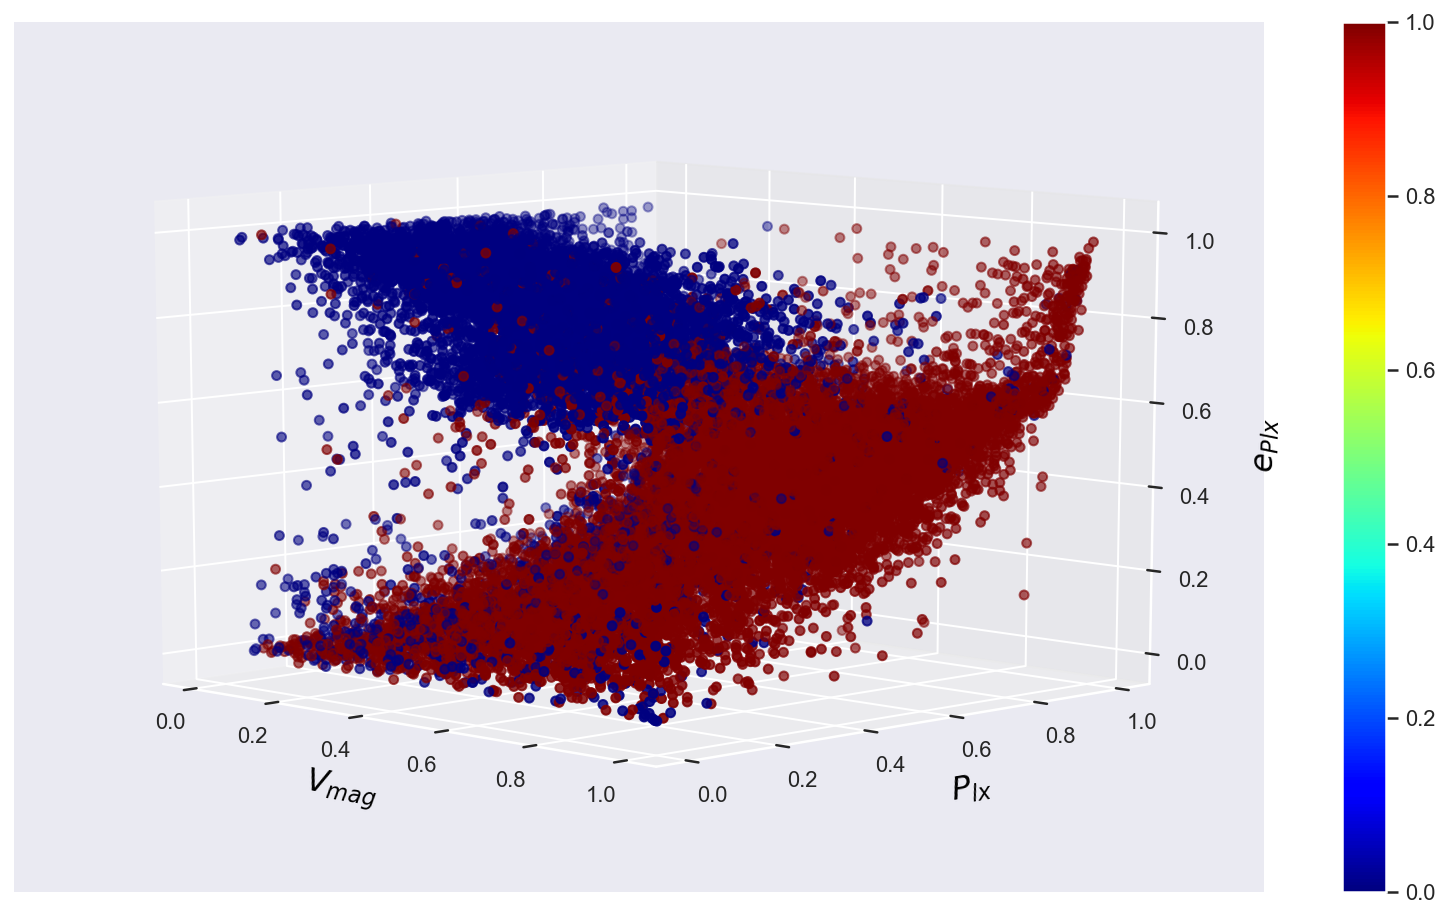

<function __main__.plot_3D.<locals>.plotter(elev=10, azim=-45)>

In [55]:
interact(plot_3D(X_train, y_train, elevation=10, azimth=-45))

#### 3D Test Plot 

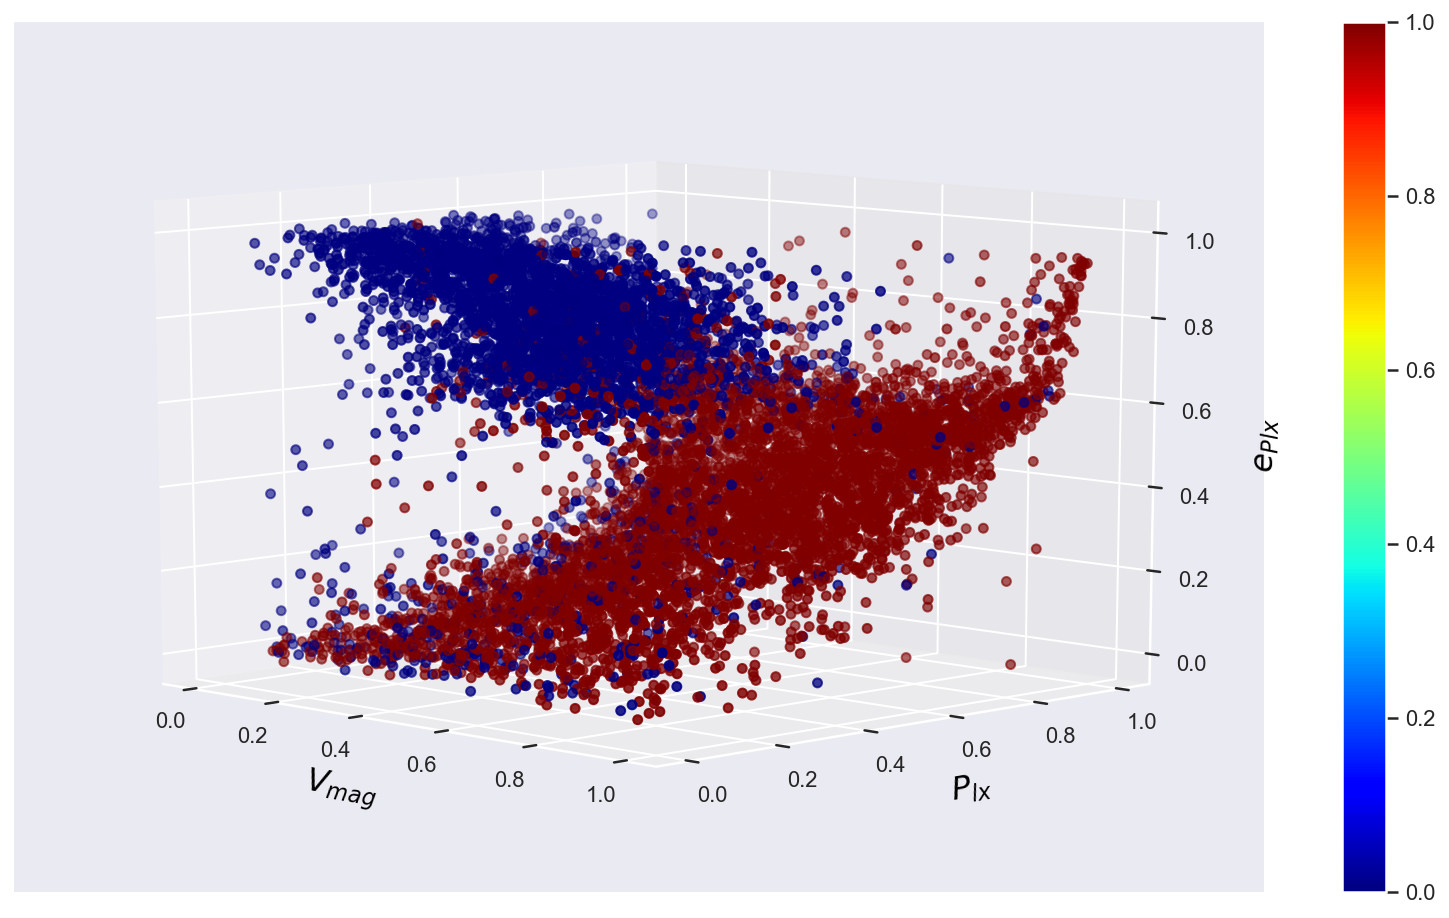

<function __main__.plot_3D.<locals>.plotter(elev=10, azim=-45)>

In [56]:
interact(plot_3D(X_test, y_test, elevation=10, azimth=-45))

- The data appears less dense in distribution, therefore, the $QuantileTransformer$ will be used

## Classifier Training

- In this case, I will try out the following classifiers;

$$LogisticRegression$$

$$RandomForestClassifier$$

$$SupportVectorMachine$$

$$K-Nearest Neighbors$$

- Again, after training, I will collect and compare several metrics of the resulting prediction and pick the classifier with the best scores

In [57]:
# Create DataFrame to Store Metrics

metrics_on_training2 = pd.DataFrame(columns=["Accuracy", "Precision", "R Score", "MSE"], 
                                   index=["Logistic Regression", "Random Forest", "SVM_linear",
                                          "SVM_rbf", "SVM_poly", "KNN"],
                                   dtype=float)

metrics_on_test2 = pd.DataFrame(columns=["Accuracy", "Precision", "R Score", "MSE"], 
                                   index=["Logistic Regression", "Random Forest", "SVM_linear", 
                                          "SVM_rbf", "SVM_poly", "KNN"], 
                                   dtype=float)

# Save predicted y_values and y_test to dataframe for later use

y_df = pd.DataFrame(y_test, columns=["y_test"])

#### Logistic Regression

- Despite using the QuantileTransformer, the still appears to be a few outliers in the data. 

- To penalize these outliers and avoid overfitting, the $L_{2}$ Ridge penalty will be used since most features appear to determine a star's Luminousity Class.

In [58]:
## Train Model
LogReg = LogisticRegression(C=0.04, class_weight=None, dual=False,
                           fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                           max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                           random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
LogReg.fit(X_train, y_train)

## Make Predictions

y_test_pr = np.round(LogReg.predict(X_test))
y_train_pr = np.round(LogReg.predict(X_train))

# Save predicted values to dataframe for later use
y_df["LogReg"] = y_test_pr

metrics_on_training2.loc["Logistic Regression", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training2.loc["Logistic Regression", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training2.loc["Logistic Regression", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training2.loc["Logistic Regression", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100



metrics_on_test2.loc["Logistic Regression", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test2.loc["Logistic Regression", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted",
                                                                                 zero_division=0)*100
metrics_on_test2.loc["Logistic Regression", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test2.loc["Logistic Regression", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### Random Forest Classifier

- Since the performance of a single decision tree will be limited, a better approach will be to aggregate the predictions of multiple trees. 

- The expectation is that aggregation should perform better than a single predictor. Hence a Random Forest was chosen


In [59]:
rfc = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rfc.fit(X_train, y_train)


## Make Predictions

y_test_pr = np.round(rfc.predict(X_test))
y_train_pr = np.round(rfc.predict(X_train))

# Save predicted values to dataframe for later use
y_df["RFC"] = y_test_pr

metrics_on_training2.loc["Random Forest", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training2.loc["Random Forest", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training2.loc["Random Forest", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training2.loc["Random Forest", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test2.loc["Random Forest", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test2.loc["Random Forest", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test2.loc["Random Forest", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test2.loc["Random Forest", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### Support Vector Machine

- In this case, the data appears to be linearly separable, hence, the Linear SVM as well as the RBF and Poly kernel methods will be implemented and subsequently compared. 

In [60]:
clf_linear = svm.SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None,
                    coef0=0.0, decision_function_shape='ovr', gamma='scale',
                    kernel='linear', max_iter=-1, probability=False, random_state=None,
                    shrinking=True, tol=0.001, verbose=False)

clf_linear.fit(X_train, y_train)


## Make Predictions

y_test_pr = np.round(clf_linear.predict(X_test))
y_train_pr = np.round(clf_linear.predict(X_train))


# Save predicted values to dataframe for later use
y_df["LinearSVM"] = y_test_pr

metrics_on_training2.loc["SVM_linear", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training2.loc["SVM_linear", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training2.loc["SVM_linear", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training2.loc["SVM_linear", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test2.loc["SVM_linear", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test2.loc["SVM_linear", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test2.loc["SVM_linear", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test2.loc["SVM_linear", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

In [61]:
clf_rbf = svm.SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None,
                    coef0=0.0, decision_function_shape='ovr', gamma='scale',
                    kernel='rbf', max_iter=-1, probability=False, random_state=None,
                    shrinking=True, tol=0.001, verbose=False)
clf_rbf.fit(X_train, y_train)


## Make Predictions

y_test_pr = np.round(clf_rbf.predict(X_test))
y_train_pr = np.round(clf_rbf.predict(X_train))

# Save predicted values to dataframe for later use
y_df["RBF_SVM"] = y_test_pr

metrics_on_training2.loc["SVM_rbf", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training2.loc["SVM_rbf", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training2.loc["SVM_rbf", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training2.loc["SVM_rbf", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test2.loc["SVM_rbf", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test2.loc["SVM_rbf", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test2.loc["SVM_rbf", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test2.loc["SVM_rbf", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

In [62]:
clf_poly = svm.SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
                    decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
                    max_iter=-1, probability=False, random_state=None, shrinking=True,
                    tol=0.001, verbose=False)
clf_poly.fit(X_train, y_train)


## Make Predictions

y_test_pr = np.round(clf_poly.predict(X_test))
y_train_pr = np.round(clf_poly.predict(X_train))

# Save predicted values to dataframe for later use
y_df["POLY_SVM"] = y_test_pr

metrics_on_training2.loc["SVM_poly", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training2.loc["SVM_poly", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training2.loc["SVM_poly", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training2.loc["SVM_poly", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100

metrics_on_test2.loc["SVM_poly", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test2.loc["SVM_poly", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test2.loc["SVM_poly", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test2.loc["SVM_poly", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### K-Nearest Neighbors

- The decision to try out KNN Classifier stems from the exploratory analysis of the data. 

In [63]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

knn.fit(X_train, y_train)


## Make Predictions

y_test_pr = np.round(knn.predict(X_test))
y_train_pr = np.round(knn.predict(X_train))


# Save predicted values to dataframe for later use
y_df["KNN"] = y_test_pr

metrics_on_training2.loc["KNN", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training2.loc["KNN", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training2.loc["KNN", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training2.loc["KNN", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100

metrics_on_test2.loc["KNN", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test2.loc["KNN", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test2.loc["KNN", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test2.loc["KNN", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

### Training Metrics Heatmap

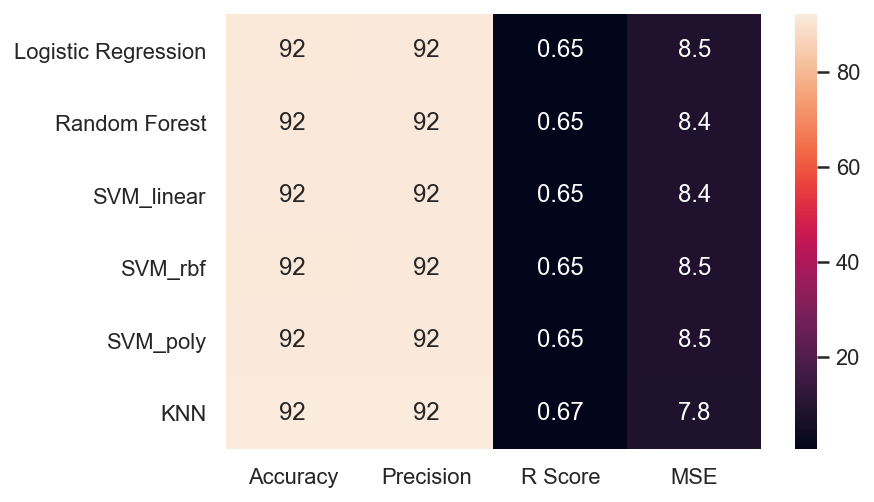

In [64]:
sns.heatmap(data=metrics_on_training2, annot=True)

### Test Metrics Heatmap

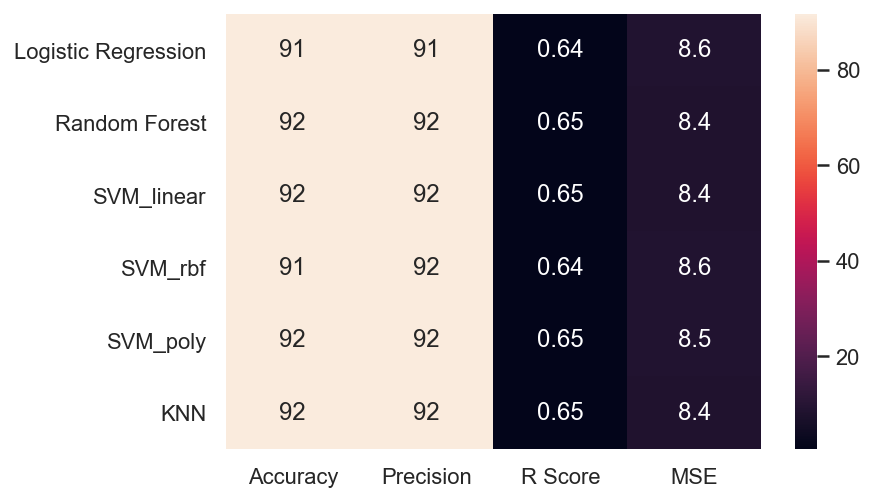

In [65]:
sns.heatmap(data=metrics_on_test2, annot=True)

### Confusion Matrix

- Since the metrics for all the models above appear approximately equal, a confusion matrix can be used to make a decision on what model to use.

- " A confusion matrix $C$ has matrix elements $C_{i,j}$ corresponding to the number of observations known to be in group $i$ but predicted to be in group $j$. 

- In other words, diagonal elements represent correct predictions, while off-diagonal elements represent mislabelling. The aim is to have large diagonal values $C_{i,i}$ of the confusion matrix " 

$$ source; towardsdatascience.com $$

Text(0.04, 0.5, 'True')

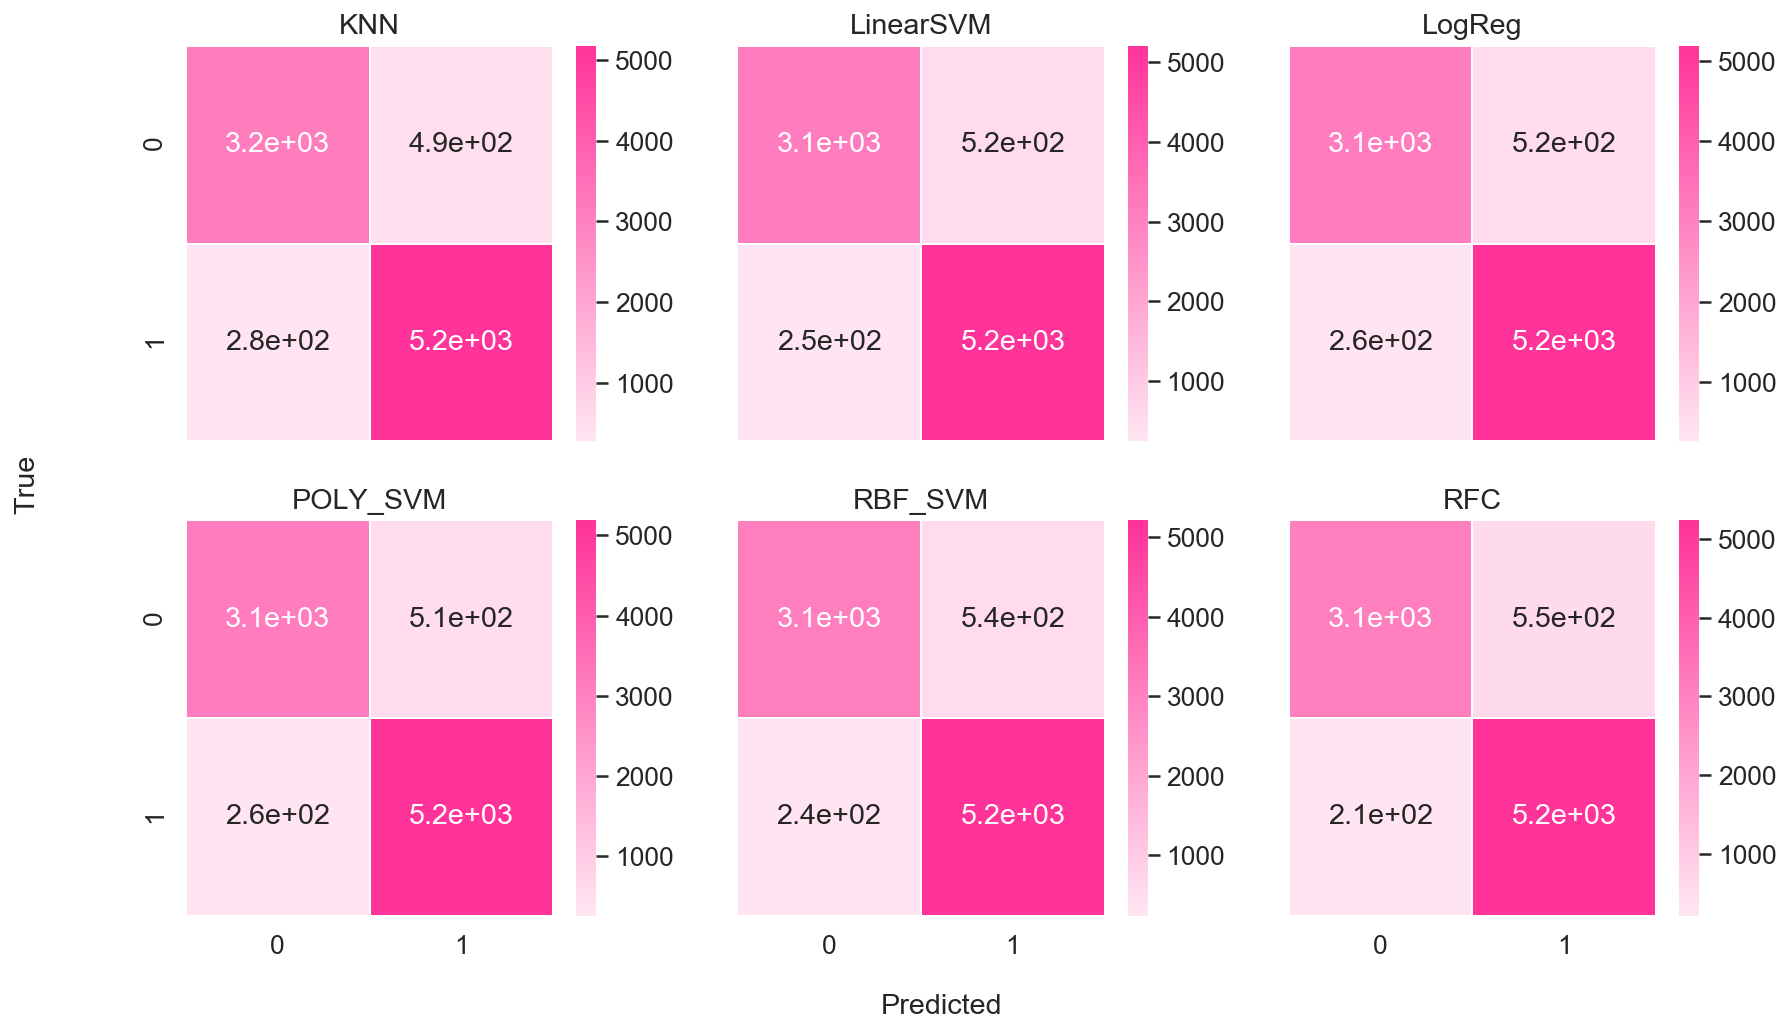

In [66]:
model_list =["KNN", "LinearSVM", "LogReg", "POLY_SVM", "RBF_SVM", "RFC"]

cm = {}

for key in model_list:
    cm[key] = confusion_matrix(y_test, y_df[key], labels=[0, 1])
    cm[key] = pd.DataFrame(cm[key], index=[0, 1], columns=[0, 1])

sns.set(font_scale=1.2)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14, 8), sharex=True, sharey=True)

sns.heatmap(cm["KNN"], ax=axs[0, 0], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["LinearSVM"], ax=axs[0, 1],  linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["LogReg"], ax=axs[0, 2], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["POLY_SVM"], ax=axs[1, 0], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["RBF_SVM"], ax=axs[1, 1], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["RFC"], ax=axs[1, 2], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)

axs[0, 0].set_title("KNN")
axs[0, 1].set_title("LinearSVM")
axs[0, 2].set_title("LogReg")
axs[1, 0].set_title("POLY_SVM")
axs[1, 1].set_title("RBF_SVM")
axs[1, 2].set_title("RFC")

fig.text(0.5, 0.04, 'Predicted', ha='center')
fig.text(0.04, 0.5, 'True', va='center', rotation='vertical')

## Comments

- The confusion matrix above indicates that despite all models seemingly predicting the same number of correct outcomes.The $Random$ $Forest$ $Classifier$ yields the least number of $False$ $Negatives$ and $False$ $Positives$. 

- For this reason, the $Random$ $Forest$ $Classifier$ will be used on the exam data.

## Predict Exam Data

- Now, I will run the  $Random$ $Forest$ $Classifier$ to predict the encoded $Dwarf$ and $Giant$ classes of the exam question data

- For the prediction, I will use the already transformed exam_data features stored in $X_{exam}$ in $Question$ $1$

- Subsequently, I will extract the star classes in string format using an algorithm that maps observations with $ClassTypes$ of 0 as $Dwarfs$ and those with $ClassTypes$ $1$ as $Giants$

- These predictions will be saved to the exam_data DataFrame as $ClassType\_Q2$ and $Name\_Q2$ where $Q2$ represents $Question 2$

In [67]:
y_exam = rfc.predict(X_exam)

exam_data["ClassType_Q2"] = y_exam

exam_data.loc[exam_data["ClassType_Q2"] == 0, "Name_Q2"] = "Dwarf"
exam_data.loc[exam_data["ClassType_Q2"] == 1, "Name_Q2"] = "Giant"

# Question Three

### Absolute Magnitude

In [68]:
data_train["Amag"] = data_train["Vmag"] + 5.0*(np.log10(data_train["Plx"]) + 1)

C:\Users\adeoy\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\adeoy\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


- The above formula throws a $RuntimeWarning:$ $divide$ $by$ $zero$ $encountered$ $in$ $log10$ 

- This is because $log_{10}$$(x)$ is undefined for $x$ $≤$ $0$. 

- This implies that there are observations with $P_{lx}$ of zero or negative

- To remedy this, I will take the absolute value of $P_{lx}$ and drop observations where $P_{lx} = 0$ 

In [69]:
data_train = data_train[data_train["Plx"] != 0]

data_train["Amag"] = data_train["Vmag"] + 5.0*(np.log10(abs(data_train["Plx"])) + 1)

### Obtain $A_{mag}$ For Exam Data

- In the same vein, I will drop observations in the exam data where $P_{lx} = 0$ 

In [70]:
exam_data[exam_data["Plx"] == 0].shape

(0, 6)

- There are no observations in the exam data observations where $P_{lx} = 0$. Therefore there is no need to drop any rows

- Obtain $A_{mag}$ using absolute value of $P_{lx}$

In [71]:
exam_data["Amag"] = exam_data["Vmag"] + 5.0*(np.log10(abs(exam_data["Plx"])) + 1)

### Select Features and Identify Label

In [72]:
X = data_train[["B-V", "Amag"]]
y = data_train["label"]

- Do the same for exam data

In [73]:
X_exam = exam_data[["B-V", "Amag"]]

### Exploratory Analysis

Text(0, 0.5, '$A_{mag}$')

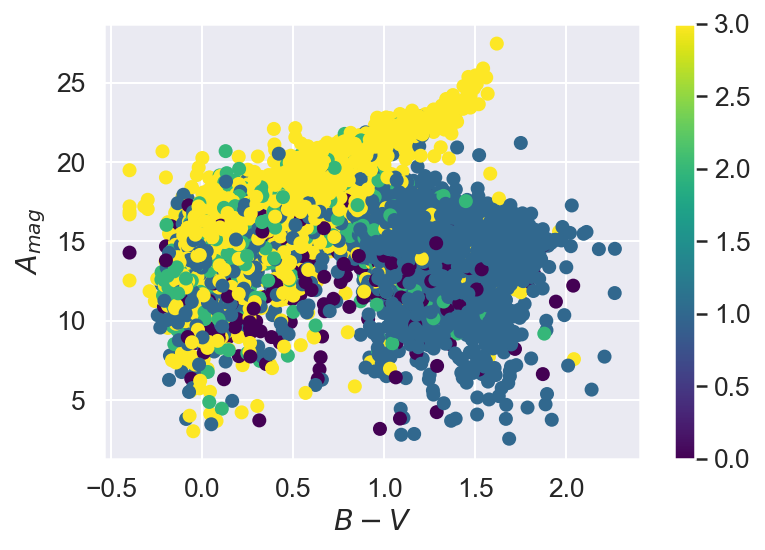

In [74]:
plt.scatter(X["B-V"].to_numpy().T, X["Amag"].to_numpy().T, c=y.to_numpy(), cmap="viridis")
plt.xlabel('$B-V$')
plt.colorbar()
plt.ylabel('$A_{mag}$')

- The exploratory analysis shown above already indicates that the features require some data preprocessing or transformations because the raw features exists on different scales. 

- This tempts one to apply preprocessing technqiues like the $MinMaxScaler$

Text(0, 0.5, '$A_{mag}$')

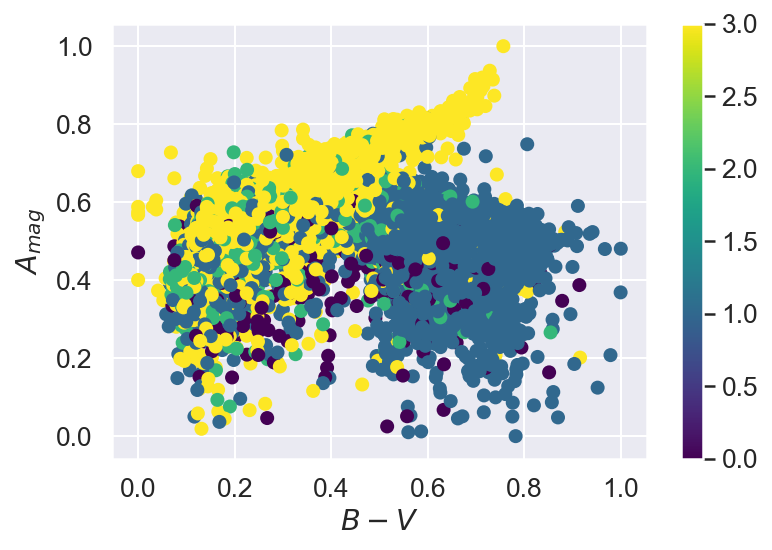

In [75]:
scaler = MinMaxScaler()
Xs = scaler.fit_transform(X)

plt.scatter(Xs[:, 0].T, Xs[:, 1].T, c=y.to_numpy(), cmap="viridis")
plt.xlabel('$B-V$')
plt.colorbar()
plt.ylabel('$A_{mag}$')

- Again, it is evident that $MinMaxScaler$ doesn't provide the desired uniform distribution as several outliers still exists in the data.

- A particularly useful transformation for obtaining uniformly distributied data is the $QuantileTransformer$ 

Text(0, 0.5, '$A_{mag}$')

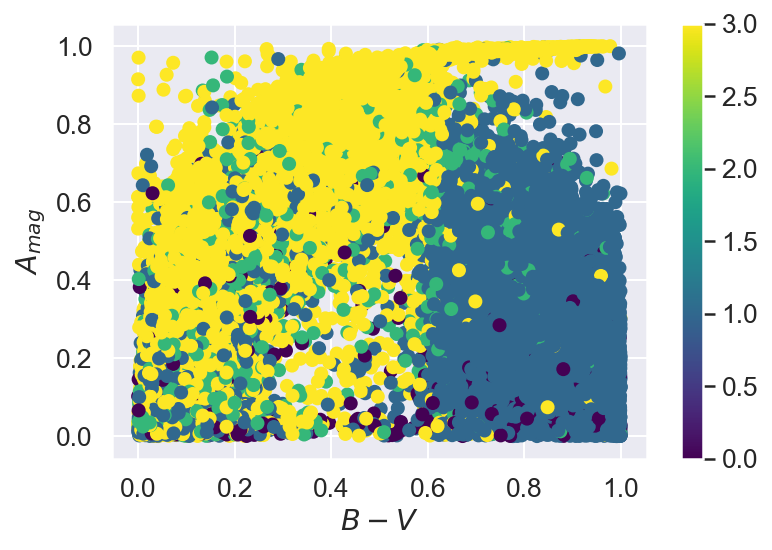

In [76]:
quantile_scaler = QuantileTransformer(output_distribution="uniform")
Xq = quantile_scaler.fit_transform(X)

plt.scatter(Xq[:, 0].T, Xq[:, 1].T, c=y.to_numpy(), cmap="viridis")
plt.xlabel('$B-V$')
plt.colorbar()
plt.ylabel('$A_{mag}$')

- Now, based on the 2D plot above, it is evident that the data appears uniformly distributed with less skew and would be more suitable for training.

## Split Data Into Test and Training Set

- As a rule of thumb, the $QuantileTransformer$ will be fit on the training set and not the entire data.

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy(), test_size=0.2, random_state=9)

quantile_scaler = QuantileTransformer()
X_train = quantile_scaler.fit_transform(X_train)
X_test = quantile_scaler.transform(X_test)

## Classifier Training

- For this classification, I will try out the same classifiers as those used in $Question 1$;

$$LogisticRegression$$

$$RandomForestClassifier$$

$$SupportVectorMachine$$

- After training, I will collect and compare several metrics of the resulting prediction and pick the classifier with the best scores

In [78]:
# Create DataFrame to Store Metrics

metrics_on_training3 = pd.DataFrame(columns=["Accuracy", "Precision", "R Score", "MSE"], 
                                   index=["Logistic Regression", "Random Forest", "SVM_rbf", "SVM_poly"],
                                   dtype=float)

metrics_on_test3 = pd.DataFrame(columns=["Accuracy", "Precision", "R Score", "MSE"], 
                                   index=["Logistic Regression", "Random Forest", "SVM_rbf", "SVM_poly"], 
                                   dtype=float)

#### Logistic Regression

- Despite using the QuantileTransformer, there still appears to be a few outliers in the data. 

- To penalize these outliers and avoid overfitting, the $L_{2}$ Ridge penalty will be used since most features appear to determine a star's Luminousity Class.

In [79]:
## Train Model
LogReg = LogisticRegression(C=0.03, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogReg.fit(X_train, y_train)

## Make Predictions

y_test_pr = np.round(LogReg.predict(X_test))
y_train_pr = np.round(LogReg.predict(X_train))


metrics_on_training3.loc["Logistic Regression", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training3.loc["Logistic Regression", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training3.loc["Logistic Regression", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training3.loc["Logistic Regression", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100



metrics_on_test3.loc["Logistic Regression", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test3.loc["Logistic Regression", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test3.loc["Logistic Regression", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test3.loc["Logistic Regression", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### Random Forest Classifier

- Since the performance of a single decision tree will be limited, a better approach will be to aggregate the predictions of multiple trees. 

- The expectation is that aggregation should perform better than a single predictor. Hence a Random Forest was chosen

In [80]:
rfc = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rfc.fit(X_train, y_train)


## Make Predictions

y_test_pr = np.round(rfc.predict(X_test))
y_train_pr = np.round(rfc.predict(X_train))


metrics_on_training3.loc["Random Forest", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training3.loc["Random Forest", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training3.loc["Random Forest", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training3.loc["Random Forest", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test3.loc["Random Forest", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test3.loc["Random Forest", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test3.loc["Random Forest", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test3.loc["Random Forest", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### Support Vector Machine

- Since the plotted distribution indicates the data is not completely linearly separable, the Linear SVM is not a favorable kernel method to use.  

- To remedy this, the RBF and Poly kernel methods will be used and subsequently compared.

In [81]:

clf_rbf = svm.SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None,
                    coef0=0.0, decision_function_shape='ovr', gamma='scale',
                    kernel='rbf', max_iter=-1, probability=False, random_state=None,
                    shrinking=True, tol=0.001, verbose=False)

clf_rbf.fit(X_train, y_train)

## Make Predictions

y_test_pr = np.round(clf_rbf.predict(X_test))
y_train_pr = np.round(clf_rbf.predict(X_train))


metrics_on_training3.loc["SVM_rbf", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training3.loc["SVM_rbf", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training3.loc["SVM_rbf", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training3.loc["SVM_rbf", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test3.loc["SVM_rbf", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test3.loc["SVM_rbf", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test3.loc["SVM_rbf", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test3.loc["SVM_rbf", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100


In [ ]:
## Make Predictions
clf_poly = clf_poly = svm.SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
                    decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
                    max_iter=-1, probability=False, random_state=None, shrinking=True,
                    tol=0.001, verbose=False)

clf_poly.fit(X_train, y_train)

y_test_pr = np.round(clf_poly.predict(X_test))
y_train_pr = np.round(clf_poly.predict(X_train))


metrics_on_training3.loc["SVM_poly", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training3.loc["SVM_poly", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training3.loc["SVM_poly", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training3.loc["SVM_poly", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100

metrics_on_test3.loc["SVM_poly", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test3.loc["SVM_poly", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test3.loc["SVM_poly", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test3.loc["SVM_poly", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100


### Training Metrics Heatmap

In [ ]:
sns.heatmap(data=metrics_on_training3, annot=True)

### Test Metrics Heatmap

In [ ]:
sns.heatmap(data=metrics_on_test3, annot=True)

## Comments

- The heatmaps above indicate that of the four models, the $Random$ $Forest$ $Classifier$ makes the best predictions on both the training and Test sets, since it has the highest Accuracy, Precision and R-score evaluation metrics but the lowest Mean Squared Error. 

- However, it is important to note that this model is not a sufficeintly good since it expresses a relatively low R-score and high MSE.

## Predict Exam Data

- Now, I will run the $Random$ $Forest$ $Classifier$ to predict the encoded $Luminousity$ $Classes$ of the exam question data

- Before that is done, the features of the exam data have to be transformed using the $QuantileTransformer$ fitted to the raw training features in this question. 

- Subsequently, I will use the inverse tramsform method of the $Label Encoder$, already fitted to the taw training data, to extract the $Lunminousity$ $Class$ on the $I - VII$ scale

- This prediction will be saved to the exam_data DataFrame as $LuminousityClass\_Q3$, where $Q3$ represents $Question 3$

In [ ]:
X_exam = quantile_scaler.transform(exam_data[["B-V", "Amag"]])

In [ ]:
y_exam = rfc.predict(X_exam)

y_exam = le.inverse_transform(y_exam)

exam_data["LuminousityClass_Q3"] = y_exam

## Decision Boundary

- The function for the decision boundary takes in the raw training data and exam data as input variables. 

In [ ]:
def plot_decision_boundary(model, X_train, y_train, X_exam, y_exam, percentage, ax=None, cmap='rainbow'):
    
    ax = ax or plt.gca()
    
    # Plot the training points
    #p = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=cmap,
    #           clim=(y_train.min(), y_train.max()), zorder=3, alpha=0.3, label="{}% Training Data".format(percentage))
    
    p = ax.scatter(X_exam[:, 0], X_exam[:, 1], c=y_exam, s=30, cmap=cmap,
               clim=(y_exam.min(), y_exam.max()), zorder=3, alpha=0.9, label="Exam Data")
        
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    
    # fit the estimator
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = 4
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    ax.set_xlabel("$B-V$")
    ax.set_ylabel("$A_{mag}$")
    plt.colorbar(p)
    ax.legend(loc='upper left', bbox_to_anchor=(1.25, 1), fontsize=7)
    plt.show()

- Since the classifiers were trained with the transformed data, the decision boundary will be plotted with transformed features from the $Quantile$ $Transformer$ of both the training set and the exam set.

- Also, the $y_{labels}$ will again be encoded to aid boundary visualization and identification of classes.


In [ ]:

lenc = LabelEncoder()
scaler = QuantileTransformer()

X_train_dec = scaler.fit_transform(data_train[["B-V", "Amag"]])
y_train_dec = lenc.fit_transform(data_train["Luminousity Class"])

X_exam_dec = scaler.transform(exam_data[["B-V", "Amag"]])
y_exam_dec = lenc.transform(exam_data["LuminousityClass_Q3"])


- To aid visualization of the data on the decision boundary, only 10% of the training data will be plotted.

- This can be done because I have shown, with the aid of 3D-Visualizations in $Questions$ $I$ and $II$, that the further splitting the training set into a subset of training and test sets yields a test set that is representative of the raw training set

In [ ]:
percentage = 10
X_train_dec, X_test_dec, y_train_dec, y_test_dec = train_test_split(X_train_dec, y_train_dec, 
                                                                    test_size=percentage/100, random_state=9)

In [ ]:

plot_decision_boundary(rfc, X_test_dec, y_test_dec, X_exam_dec, y_exam_dec, percentage, ax=None)


# Question Four

- Here, we again use the two features $B-V$ and $A_{mag}$ but in this case to predict $Giant$ and $Dwarf$ class types

### Select Features and Identify Label

In [ ]:
X = data_train[["B-V", "Amag"]]
y = data_train["ClassType"]

- Same will be done for exam data

In [ ]:
X_exam = exam_data[["B-V", "Amag"]]

### Exploratory Analysis

In [ ]:
plt.scatter(X["B-V"].to_numpy().T, X["Amag"].to_numpy().T, c=y.to_numpy(), cmap="viridis")
plt.xlabel('$B-V$')
plt.colorbar()
plt.ylabel('$A_{mag}$')

- The exploratory analysis shown above already indicates that the features require some data preprocessing or transformations because the raw features exists on different scales. 

- This tempts one to apply preprocessing technqiues like the $MinMaxScaler$

In [ ]:
scaler = MinMaxScaler()
Xs = scaler.fit_transform(X)

plt.scatter(Xs[:, 0].T, Xs[:, 1].T, c=y.to_numpy(), cmap="viridis")
plt.xlabel('$B-V$')
plt.colorbar()
plt.ylabel('$A_{mag}$')

- Again, it is evident that $MinMaxScaler$ doesn't provide the desired uniform distribution as several outliers still exists in the data.

- A particularly useful transformation for obtaining uniformly distributied data is the $QuantileTransformer$

In [ ]:
quantile_scaler = QuantileTransformer(output_distribution="uniform")
Xq = quantile_scaler.fit_transform(X)

plt.scatter(Xq[:, 0].T, Xq[:, 1].T, c=y.to_numpy(), cmap="viridis")
plt.xlabel('$B-V$')
plt.colorbar()
plt.ylabel('$A_{mag}$')

## Split Data Into Test and Training Set

- As a rule of thumb, the $QuantileTransformer$ will be fit on the training set and not the entire data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy(), test_size=0.2, random_state=9)

quantile_scaler = QuantileTransformer()
X_train = quantile_scaler.fit_transform(X_train)
X_test = quantile_scaler.transform(X_test)

## Classifier Training

- For this classification, I will try out the same classifiers as those used in $Question 2$;

$$LogisticRegression$$

$$RandomForestClassifier$$

$$SupportVectorMachine$$

$$K-Nearest Neighbors$$

- After training, I will collect and compare several metrics of the resulting prediction and pick the classifier with the best scores

In [ ]:
# Create DataFrame to Store Metrics

metrics_on_training4 = pd.DataFrame(columns=["Accuracy", "Precision", "R Score", "MSE"], 
                                   index=["Logistic Regression", "Random Forest", "SVM_linear", "SVM_rbf", "SVM_poly", "KNN"],
                                   dtype=float)

metrics_on_test4 = pd.DataFrame(columns=["Accuracy", "Precision", "R Score", "MSE"], 
                                   index=["Logistic Regression", "Random Forest", "SVM_linear", "SVM_rbf", "SVM_poly", "KNN"],
                                   dtype=float)

# Save predicted y_values and y_test to dataframe for later use

y_df = pd.DataFrame(y_test, columns=["y_test"])

#### Logistic Regression

- Despite using the QuantileTransformer, there still appears to be a few outliers in the data. 

- To penalize these outliers and avoid overfitting, the $L_{2}$ Ridge penalty will be used since most features appear to determine a star's Luminousity Class.


In [ ]:
## Train Model
LogReg = LogisticRegression(C=0.11, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogReg.fit(X_train, y_train)

## Make Predictions

y_test_pr = np.round(LogReg.predict(X_test))
y_train_pr = np.round(LogReg.predict(X_train))

# Save predicted values to dataframe for later use
y_df["LogReg"] = y_test_pr

metrics_on_training4.loc["Logistic Regression", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training4.loc["Logistic Regression", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training4.loc["Logistic Regression", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training4.loc["Logistic Regression", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test4.loc["Logistic Regression", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test4.loc["Logistic Regression", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted",
                                                                                 zero_division=0)*100
metrics_on_test4.loc["Logistic Regression", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test4.loc["Logistic Regression", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100


#### Random Forest Classifier

- Since the performance of a single decision tree will be limited, a better approach will be to aggregate the predictions of multiple trees. 

- The expectation is that aggregation should perform better than a single predictor. Hence a Random Forest was chosen

In [ ]:
rfc = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rfc.fit(X_train, y_train)


## Make Predictions

y_test_pr = np.round(rfc.predict(X_test))
y_train_pr = np.round(rfc.predict(X_train))

# Save predicted values to dataframe for later use
y_df["RFC"] = y_test_pr

metrics_on_training4.loc["Random Forest", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training4.loc["Random Forest", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training4.loc["Random Forest", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training4.loc["Random Forest", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test4.loc["Random Forest", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test4.loc["Random Forest", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test4.loc["Random Forest", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test4.loc["Random Forest", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### Support Vector Machine

- In this case, the data appears to be linearly separable, hence, the Linear SVM as well as the RBF and Poly kernel methods will be implemented and subsequently compared. 


In [ ]:
clf_linear = svm.SVC(C=0.26, break_ties=False, cache_size=200, class_weight=None,
                coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
                kernel='linear', max_iter=-1, probability=False, random_state=None,
                shrinking=True, tol=0.001, verbose=False)

clf_linear.fit(X_train, y_train)


## Make Predictions

y_test_pr = np.round(clf_linear.predict(X_test))
y_train_pr = np.round(clf_linear.predict(X_train))


# Save predicted values to dataframe for later use
y_df["LinearSVM"] = y_test_pr

metrics_on_training4.loc["SVM_linear", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training4.loc["SVM_linear", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training4.loc["SVM_linear", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training4.loc["SVM_linear", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test4.loc["SVM_linear", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test4.loc["SVM_linear", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test4.loc["SVM_linear", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test4.loc["SVM_linear", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100


In [ ]:
clf_rbf = svm.SVC(C=0.5858585858585859, break_ties=False, cache_size=200, class_weight=None,
                    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
                    kernel='rbf', max_iter=-1, probability=False, random_state=None,
                    shrinking=True, tol=0.001, verbose=False)


clf_rbf.fit(X_train, y_train)


## Make Predictions

y_test_pr = np.round(clf_rbf.predict(X_test))
y_train_pr = np.round(clf_rbf.predict(X_train))

# Save predicted values to dataframe for later use
y_df["RBF_SVM"] = y_test_pr

metrics_on_training4.loc["SVM_rbf", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training4.loc["SVM_rbf", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training4.loc["SVM_rbf", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training4.loc["SVM_rbf", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test4.loc["SVM_rbf", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test4.loc["SVM_rbf", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test4.loc["SVM_rbf", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test4.loc["SVM_rbf", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

In [ ]:
clf_poly = svm.SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
                decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
                max_iter=-1, probability=False, random_state=None, shrinking=True,
                tol=0.001, verbose=False)

clf_poly.fit(X_train, y_train)


## Make Predictions

y_test_pr = np.round(clf_poly.predict(X_test))
y_train_pr = np.round(clf_poly.predict(X_train))

# Save predicted values to dataframe for later use
y_df["POLY_SVM"] = y_test_pr

metrics_on_training4.loc["SVM_poly", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training4.loc["SVM_poly", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training4.loc["SVM_poly", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training4.loc["SVM_poly", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100

metrics_on_test4.loc["SVM_poly", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test4.loc["SVM_poly", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test4.loc["SVM_poly", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test4.loc["SVM_poly", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### K-Nearest Neighbors

- The decision to try out KNN Classifier stems from the exploratory analysis of the data. 

In [ ]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

knn.fit(X_train, y_train)


## Make Predictions

y_test_pr = np.round(knn.predict(X_test))
y_train_pr = np.round(knn.predict(X_train))


# Save predicted values to dataframe for later use
y_df["KNN"] = y_test_pr

metrics_on_training4.loc["KNN", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training4.loc["KNN", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training4.loc["KNN", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training4.loc["KNN", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100

metrics_on_test4.loc["KNN", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test4.loc["KNN", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test4.loc["KNN", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test4.loc["KNN", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

### Training Metrics Heatmap

In [ ]:
sns.heatmap(data=metrics_on_training4, annot=True)

### Test Metrics Heatmap

In [ ]:
sns.heatmap(data=metrics_on_test4, annot=True)

### Confusion Matrix

- Since the metrics for all the models above appear approximately equal, a confusion matrix can be used to make a decision on what model to use.

In [ ]:
model_list =["KNN", "LinearSVM", "LogReg", "POLY_SVM", "RBF_SVM", "RFC"]

cm = {}

for key in model_list:
    cm[key] = confusion_matrix(y_test, y_df[key], labels=[0, 1])
    cm[key] = pd.DataFrame(cm[key], index=[0, 1], columns=[0, 1])

sns.set(font_scale=1.2)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14, 8), sharex=True, sharey=True)

sns.heatmap(cm["KNN"], ax=axs[0, 0], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["LinearSVM"], ax=axs[0, 1],  linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["LogReg"], ax=axs[0, 2], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["POLY_SVM"], ax=axs[1, 0], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["RBF_SVM"], ax=axs[1, 1], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["RFC"], ax=axs[1, 2], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)

axs[0, 0].set_title("KNN")
axs[0, 1].set_title("LinearSVM")
axs[0, 2].set_title("LogReg")
axs[1, 0].set_title("POLY_SVM")
axs[1, 1].set_title("RBF_SVM")
axs[1, 2].set_title("RFC")

fig.text(0.5, 0.04, 'Predicted', ha='center')
fig.text(0.04, 0.5, 'True', va='center', rotation='vertical')

## Comments

- Again, despite the metric heatmap indicating approximately equal scores for all trained model, the $Random$ $Forest$ $Classifier$ appears to be the best classifer to choose because it exhibits the lowest Mean Squared Error on both the training and test sets. 

- This is also evident in the confusion matrix shown above as the $Random$ $Forest$ $Classifier$ predicts the lowest number of $False$ $Positives$ and $False$ $Negatives$. 

## Predict Exam Data

- Now, I will run the $Random$ $Forest$ $Classifier$ to predict the encoded $Dwarf$ and $Giant$ classes of the exam question data

- The features will have to first be transformed accordingly.

- Subsequently, I will extract the star classes in string format using an algorithm that maps observations with $ClassTypes$ of 0 as $Dwarfs$ and those with $ClassTypes$ $1$ as $Giants$

- These predictions will be saved to the exam_data DataFrame as $ClassType\_Q4$ and $Name\_Q4$ where $Q4$ represents $Question 4$

In [ ]:
X_exam = quantile_scaler.transform(X_exam)

y_exam = clf_rbf.predict(X_exam)

exam_data["ClassType_Q4"] = y_exam

exam_data.loc[exam_data["ClassType_Q4"] == 0, "Name_Q4"] = "Dwarf"
exam_data.loc[exam_data["ClassType_Q4"] == 1, "Name_Q4"] = "Giant"

### Decision Boundary

- Since the classifiers were trained with the transformed data, the decision boundary will be plotted with transformed features from the $Quantile$ $Transformer$ of both the training set and the exam set.

In [ ]:
lenc = LabelEncoder()
scaler = QuantileTransformer()

X_train_dec = scaler.fit_transform(data_train[["B-V", "Amag"]])
y_train_dec = data_train["ClassType"].to_numpy()

X_exam_dec = scaler.transform(exam_data[["B-V", "Amag"]])
y_exam_dec = exam_data["ClassType_Q4"].to_numpy()


In [ ]:
percentage = 10
X_train_dec, X_test_dec, y_train_dec, y_test_dec = train_test_split(X_train_dec, y_train_dec, 
                                                                    test_size=percentage/100, random_state=9)

In [ ]:
plot_decision_boundary(rfc, X_test_dec, y_test_dec, X_exam_dec, y_exam_dec, percentage, ax=None, cmap='rainbow')

# Save Exam Reuslts to File

In [ ]:
exam_data.to_csv("exam_solution.csv")

# Appendix

- Parameters for fitting were chosen accoriding to the $GridSearchCV$ parameter fitting algorithm. 

- An example has been shown for the $KNeighborsClassifier$ where optimization was done for the paramter $n_neighbors$

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
X = data_train[["B-V", "Amag"]]
y = data_train["ClassType"]
X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy(), test_size=0.2, random_state=9)

estimator = Pipeline([("scaler", QuantileTransformer()), ("clf", KNeighborsClassifier())])
parameters = {"scaler__output_distribution": ["uniform", "normal"], "clf__n_neighbors": range(0, 10)}
gs = GridSearchCV(estimator,parameters, cv=5, n_jobs=2, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)
gs.best_estimator_